## **Before you start**

Make a copy of this Colab by clicking on File > Save a Copy in Drive

After making a copy, add your student id, last name, and first name to the title.

In [ ]:
student_name = "Ricardo Sillas"
student_id = "88613474"
print("Identifying Information: ",student_name+","+student_id); # Don't change this line.

Identifying Information:  Ricardo Sillas,88613474


# Classifying Images


This lab is about classifying images. Each input is a grid of pixel values and each output is a label from a small set of labels. You will start with a simple binary classifier and finish with a multi-class one.

### Grading

This assignment is worth a total of 100 points.

In [ ]:
# Import the libraries we'll use below.
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns  # for nicer plots
sns.set(style='darkgrid')  # default style

import tensorflow as tf
from tensorflow import keras
from keras import metrics

## Understanding the data
We'll be using the [Fashion MNIST](https://github.com/zalandoresearch/fashion-mnist) dataset. This consists of 70,000 grayscale images (28x28). Each image is associated with 1 of 10 classes. The dataset was split by the creators; there are 60,000 training images and 10,000 test images. 

Fashion MNIST classes:
* T-shirt/top
* Trouser
* Pullover
* Dress
* Coat
* Sandal
* Shirt
* Sneaker
* Bag
* Ankle boot

Before doing anything, let's make sure we understand what we're working with. 

### Load the data
Tensorflow includes a growing [library of datasets](https://www.tensorflow.org/datasets/catalog/overview) and makes it easy to load them in numpy arrays.

In [ ]:
from keras.datasets import fashion_mnist

# Load the Fashion MNIST dataset.
(X_train, Y_train), (X_test, Y_test) = fashion_mnist.load_data()

# Flatten Y_train and Y_test, so they become vectors of label values.
# The label for X_train[0] is in Y_train[0].
Y_train = Y_train.flatten()
Y_test = Y_test.flatten()

np.random.seed(0) # For reproducibility purposes

# Shuffle the order of the training examples.
indices = np.arange(X_train.shape[0])
shuffled_indices = np.random.permutation(indices)

X_train = X_train[shuffled_indices]
Y_train = Y_train[shuffled_indices]

4422102/4422102 [==============================] - 0s 0us/step


### Basic Analysis
Notice that `X_train`, `Y_train`, `X_test`, and `Y_test` are all numpy arrays. Let's print their shapes to confirm.

In [ ]:
# Show the data shapes.
print('X_train.shape:', X_train.shape)
print('Y_train.shape:', Y_train.shape)
print('X_test.shape:', X_test.shape)
print('Y_test.shape:', Y_test.shape)

X_train.shape: (60000, 28, 28)
Y_train.shape: (60000,)
X_test.shape: (10000, 28, 28)
Y_test.shape: (10000,)


Notice that there are 60,000 instances in `X_train`. Each of these is a grayscale image represented by an 28-by-28 array of grayscale pixel values between 0 and 255 (the larger the value, the lighter the pixel). Before we continue, let's apply linear scaling to our pixel values, so they all fall between 0 and 1.

In [ ]:
# Pixel values range from 0 to 255. To normalize the data, we just need to 
# divide all values by 255.
X_train = X_train / 255
X_test = X_test / 255

In class, we talked about features - properties that characterize our data. Here, we treat **every pixel value as a separate feature**, so each input example has 28x28 (784) features!

Fashion MNIST images have one of 10 possible labels (shown above). Since the labels are indices 0-9, let's keep a list of (string) names for convenience.

In [ ]:
label_names = ['t-shirt', 'trouser', 'pullover', 'dress', 'coat',
               'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']

# Show the first 5 training labels.
print('First 5 label values:', Y_train[0:5])
print('Mapped to their names:', [label_names[i] for i in Y_train[0:5]])


First 5 label values: [0 2 6 5 2]
Mapped to their names: ['t-shirt', 'pullover', 'shirt', 'sandal', 'pullover']


Next let's use the `imshow` function to look at the first few images in the training set.

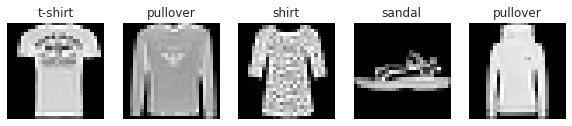

In [ ]:
# Create a figure with subplots. This returns a list of object handles in axs
# which we can use populate the plots.
fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(10,5))
for i in range(5):
  image = X_train[i]
  label = Y_train[i]
  label_name = label_names[label]
  axs[i].imshow(image, cmap='gray')  # imshow renders a 2D grid
  axs[i].set_title(label_name)
  axs[i].axis('off')
plt.show()

#### Exercise 1

Display the first 5 images for each class in a 10x5 grid. Feel free to use the code above to get started. Here's a [link](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.subplots.html) to matplotlib's documentation. 

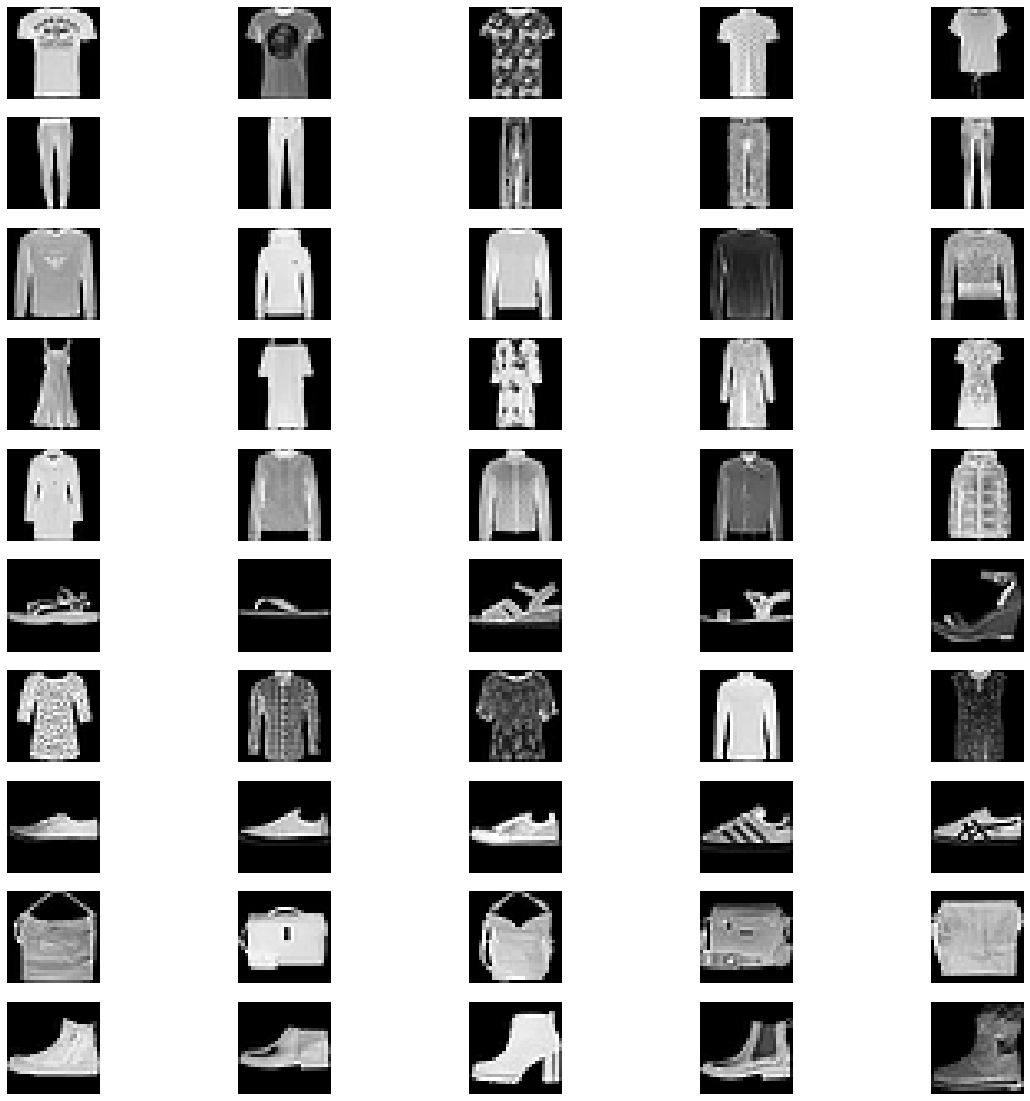

In [ ]:
fig, axs = plt.subplots(nrows=len(label_names), ncols=5, figsize=(20,20))
l=0
for i in label_names:
  j,k = 0,0
  while j < 5 or k >= len(Y_train):
    if i != label_names[Y_train[k]]:
      k+=1
      continue
    image = X_train[k]
    label = Y_train[k]
    label_name = label_names[label]
    axs[l][j].imshow(image, cmap='gray')  # imshow renders a 2D grid
    axs[l][j].axis('off')
    k+=1
    j+=1
  l+=1
plt.show()

## Problem Definition: Sneaker Classifier
There are many things we can do with this dataset. Following our lectures, let's start with binary classification. We'll use the k-nearest neighbors (k-NN) algorithm described in class to build a sneaker classifier. Our positive examples ($y=1$) will be sneaker images (class 7) and our negative examples ($y=0$) will be all other images.

The idea is that our k-NN model, given an image $x$, will produce $\hat{y}$, the probability that $x$ is a sneaker.

### Instance Based Learning

Instance-based learning is often termed lazy learning, as there is typically no “transformation” of training instances into more general
representations

Instead, the presented training data are simply stored and, when a new
query instance is encountered, a set of similar, related instances is
retrieved from memory and used to classify the new query instance

Hence, instance-based learners never form an explicit general hypothesis
regarding the target function. They simply compute the classification of
each new query instance as needed

#### K-Nearest Neighbors

The simplest, most used instance-based learning algorithm is the k-nearest neighbors algorithm. 

k-NN assumes that all instances are points in some n-dimensional space and defines neighbors in terms of distance (usually Euclidean in R-space), where k is the number of neighbors considered.

Properties:
1) All possible points within a sample's Voronoi cell are the nearest neighboring points for that sample
2) For any sample, the nearest sample is determined by the closest Voronoi cell
edge


##### Graphic Depiction

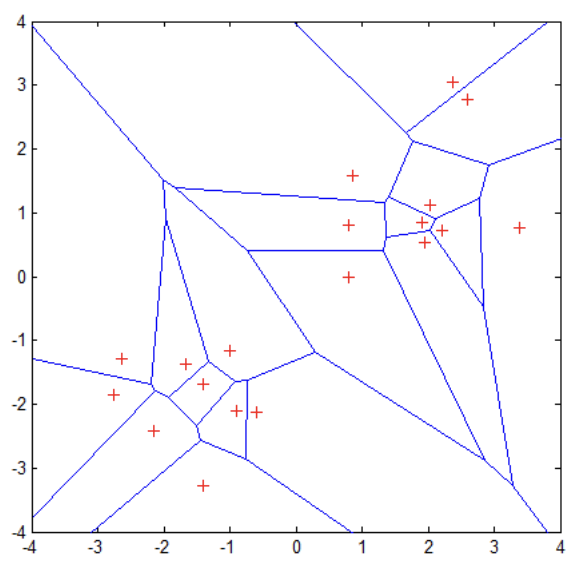

Using the second property, the k-NN classification rule is to assign to
a test sample the majority category label of its k nearest training
samples
In practice, k is usually chosen to be odd, so as to reduce the
probability of ties
The k = 1 rule is generally called the nearest-neighbor classification
rule. 

### Data Preprocessing
Before we continue, we need to prepare the data for this binary classification task. We'll map sneaker image laebls to 1 (the positive class) and all other images to 0 (the negative class).

Programming note: Numpy allows us to perform what is called [boolean array indexing](https://docs.scipy.org/doc/numpy/reference/arrays.indexing.html#boolean-array-indexing)
This means that a numpy array $A$ can be indexed using a boolean array $B$
as follows: $A[B]$.
We'll take advantage of this type of indexing to prepare the labels for our binary classification task below.

In [ ]:
# Make copies of the original labels.
Y_train_binary = np.copy(Y_train)
Y_test_binary = np.copy(Y_test)

# Update labels: 1 for sneaker images; 0 for the rest.
# Note that a boolean array is created when Y_train_binary != 7 is evaluated.
Y_train_binary[Y_train_binary != 7] = 0.0 
Y_train_binary[Y_train_binary == 7] = 1.0
Y_test_binary[Y_test_binary != 7] = 0.0
Y_test_binary[Y_test_binary == 7] = 1.0
# Cool, right?

#### Exercise 2 

Let's briefly investigate some statistical differences between sneaker and non-sneaker images.

1.   Find all sneaker images in `X_train` and compute the [mean](https://numpy.org/doc/stable/reference/generated/numpy.mean.html) and [standard deviation](https://numpy.org/doc/stable/reference/generated/numpy.std.html) of the center pixel value across all **sneaker** images. The center pixel is located at position [14, 14].

2.   Find all non-sneaker images in `X_train` and compute the mean and standard deviation of the center pixel values across all **non-sneaker** images. The center pixel is located at position [14, 14].

3. Repeat 1 and 2 for the pixel located at positon [3, 14].

In [ ]:
sneaker_index = np.where(Y_train_binary == 1)
others_index = np.where(Y_train_binary == 0)

# Problem 1
print("Mean of sneakers at (14,14): ", np.mean(X_train[sneaker_index][14][14]))
print("Standard deviation of sneakers at (14,14):", np.std(X_train[sneaker_index][14][14]), end = '\n\n')

# Problem 2
print("Mean of non-sneakers at (14,14): ", np.mean(X_train[others_index][14][14]))
print("Standard deviation of non-sneakers at (14,14):", np.std(X_train[others_index][14][14]), end = '\n\n')

# Problem 3
print("Mean of sneakers at (3,14): ", np.mean(X_train[sneaker_index][3][14]))
print("Standard deviation of sneakers at (3,14):", np.std(X_train[sneaker_index][3][14]), end = '\n\n')

print("Mean of non-sneakers at (3,14): ", np.mean(X_train[others_index][3][14]))
print("Standard deviation of non-sneakers at (3,14):", np.std(X_train[others_index][3][14]), end = '\n\n')

Mean of sneakers at (14,14):  0.4780112044817928
Standard deviation of sneakers at (14,14): 0.3383870309353462

Mean of non-sneakers at (14,14):  0.7149859943977591
Standard deviation of non-sneakers at (14,14): 0.32517796365671064

Mean of sneakers at (3,14):  0.3904761904761905
Standard deviation of sneakers at (3,14): 0.2901495696159397

Mean of non-sneakers at (3,14):  0.28165266106442577
Standard deviation of non-sneakers at (3,14): 0.3253637052510763



### Baseline

When dealing with classification problems, a simple, but useful baseline is to select the *majority* class (the most common label in the training set) and use it as the prediction for all inputs.

Our training dataset consists of 6,000 sneaker examples (10%), and 54,000 non-sneaker images (90%), so our majority class baseline classifies everything as *non-sneaker*, and will have an accuracy of 90%. We will see if we can beat this baseline with k-NN.

In [ ]:
print('Number of sneaker images in training set:', (Y_train_binary == 1).sum())
print('Number of non-sneaker images in training set:', (Y_train_binary == 0).sum())

Number of sneaker images in training set: 6000
Number of non-sneaker images in training set: 54000


### k-NN Implementation

Every image in our dataset is represenyed by an 28-by-28 array (2D). To make things easier, let's *flatten* X_train and X_test so each image is represented by an array (1D) of size 784 (28*28). 

In [ ]:
X_train = X_train.reshape(X_train.shape[0],-1)
X_test = X_test.reshape(X_test.shape[0],-1)
print(X_train.shape)
print(X_test.shape)


(60000, 784)
(10000, 784)


#### Exercise 3 

Implement the **weighted** version of knn using the following algorithm:





##### k-NN algorithm (binary classification)


```
Input: X_train, Y_train, X_test, k (number of neighbors)
Output: pred - the predicted probability for each example in x_test to be a member of the positive class

for every example x_i in x_test:
    find the distance from x_i to every instance in x_train
    find the k examples in x_train with smallest distance to x_i (the k-nearest neighbors)
    pred[i] = number of positive neighbors / k (unweighted)
    or
    pred[i] = w_neighbor_1 * y_neighbor_1 + ... + w_neighbor_k * y_neighbor_k (weighted)
    where w_neighbor_1 + ... + w_neighbor_k = 1 and the weight assigned to a
    neighbor is inversely proportional to its distance to x_i 

```


In [ ]:
def knn(X_train, Y_train_binary, X_test, k):

  pred = np.zeros(X_test.shape[0])
  dist = np.zeros(X_train.shape[0])

  for i in range(X_test.shape[0]):
    test_example = X_test[i]
    for j in range(X_train.shape[0]):
      dist[j] = np.sqrt(np.sum((X_test[i]-X_train[j])**2))
    
    sort_indices = np.argsort(dist)
    nearest_dist = dist[sort_indices[:k]]
    y_neighbors = Y_train_binary[sort_indices[:k]]

    nearest_dist /= np.sum(nearest_dist)

    pred[i] = np.sum(nearest_dist * y_neighbors)

  return pred

### Evaluation
To turn probabilities into binary predictions, we need to choose a classification threshold. A probability greater than or equal to threshold indicates class *sneaker*, while a value less than the threshold indicates class *non-sneaker*. Once we have binary predictions, we can evaluate performance with some different metrics.

A **true positive** is an outcome where the model correctly predicts the positive class. Similarly, a **true negative** is an outcome where the model correctly predicts the negative class.

A **false positive** is an outcome where the model incorrectly predicts the positive class. And a **false negative** is an outcome where the model incorrectly predicts the negative class.

Using these, we can construct a **confusion matrix**, a table that summarizes performance using these 4 result categories.

|                     | Sneaker (Actual)    | Non-Sneaker (Actual) |
|---------------------|-----------------|------------------|
| **Sneaker (Predicted)**     | Number of True Positives  | Number of False Positives  |
| **Non-Sneaker (Predicted)** | Number of False Negatives | Number of True Negatives   |


**Accuracy** is the fraction of examples our model classified correctly (correct / total):

\begin{equation}
Accuracy = \frac{TP + TN}{TP + TN + FP + FN}
\end{equation}

**Precision** is the proportion of positive predictions that were actually correct:

\begin{equation}
Precision = \frac{TP}{TP + FP}
\end{equation}

**Recall** is the proportion of actual positives that were predicted correctly:

\begin{equation}
Recall = \frac{TP}{TP + FN}
\end{equation}

Changing the threshold will change precision and recall, typically with a trade-off: improving precision reduces recall (and vice-versa).

#### Exercise 4


Test your implementation of knn using k=5. Then, do the following for each of these classification thresholds [0.1, 0.3, 0.5, 0.7, 0.9] using `pred` (predicted probabilities) and `Y_test_binary` (actual labels):

1.   Compute and print counts of [tp, tn, fp, fn]
2.   Compute and print the accuracy, precision, and recall.

**You are not allowed to use other libraries that might do this for you. You may only use numpy**

In [ ]:
Y_predictions = knn(X_train, Y_train_binary, X_test, 5)

threshold1 = np.copy(Y_predictions)
threshold2 = np.copy(Y_predictions)
threshold3 = np.copy(Y_predictions)
threshold4 = np.copy(Y_predictions)
threshold5 = np.copy(Y_predictions)

def get_information(threshold, value):
  threshold[threshold >= value] = 1
  threshold[threshold < value] = 0
  tp = np.sum(threshold * Y_test_binary)
  tn = threshold.size - np.count_nonzero(threshold + Y_test_binary)
  fp = np.sum(threshold) - tp
  fn = (threshold.size -np.count_nonzero(threshold)) - tn
  return [tp, tn, fp, fn]

info1 = get_information(threshold1, 0.1)
print('tp: ', info1[0], '\ntn: ', info1[1], '\nfp: ', info1[2], '\nfn: ', info1[3],
      '\naccuracy: ', (info1[0]+info1[1])/(info1[0]+info1[1]+info1[2]+info1[3]), 
      '\nprecision: ', info1[0]/(info1[0]+info1[2]), '\nrecall: ', info1[0]/(info1[0]+info1[3]), end = '\n\n')

info2 = get_information(threshold2, 0.3)
print('tp: ', info2[0], '\ntn: ', info2[1], '\nfp: ', info2[2], '\nfn: ', info2[3],
      '\naccuracy: ', (info2[0]+info2[1])/(info2[0]+info2[1]+info2[2]+info2[3]), 
      '\nprecision: ', info2[0]/(info2[0]+info2[2]), '\nrecall: ', info2[0]/(info2[0]+info2[3]), end = '\n\n')

info3 = get_information(threshold3, 0.5)
print('tp: ', info3[0], '\ntn: ', info3[1], '\nfp: ', info3[2], '\nfn: ', info3[3],
      '\naccuracy: ', (info3[0]+info3[1])/(info3[0]+info3[1]+info3[2]+info3[3]), 
      '\nprecision: ', info3[0]/(info3[0]+info3[2]), '\nrecall: ', info3[0]/(info3[0]+info3[3]), end = '\n\n')

info4 = get_information(threshold4, 0.7)
print('tp: ', info4[0], '\ntn: ', info4[1], '\nfp: ', info4[2], '\nfn: ', info4[3],
      '\naccuracy: ', (info4[0]+info4[1])/(info4[0]+info4[1]+info4[2]+info4[3]), 
      '\nprecision: ', info4[0]/(info4[0]+info4[2]), '\nrecall: ', info4[0]/(info4[0]+info4[3]), end = '\n\n')

info5 = get_information(threshold5, 0.9)
print('tp: ', info4[0], '\ntn: ', info4[1], '\nfp: ', info4[2], '\nfn: ', info4[3],
      '\naccuracy: ', (info4[0]+info4[1])/(info4[0]+info4[1]+info4[2]+info4[3]), 
      '\nprecision: ', info4[0]/(info4[0]+info4[2]), '\nrecall: ', info4[0]/(info4[0]+info4[3]), end = '\n\n')

### Analyze Classification Mistakes

Our predictions are not perfect. Regardless of the classification threshold we choose, it misclassifies some images. Let's take a look at some of the images that our model misclassified.

#### Exercise 5

1.   Display 5 images that were erroneously classified as sneaker (threshold = 0.5).
2.   Display 5 images that were erroneously classified as non-sneaker (threshold = 0.5).

You may want to reshape X_test so you can display the images `X_test = X_test.reshape(X_test.shape[0],28,28)`


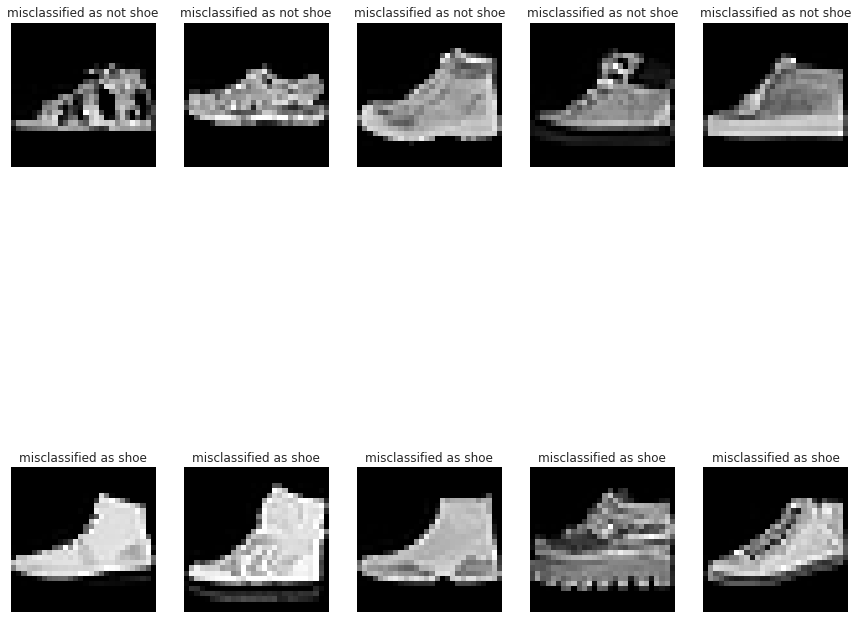

In [ ]:
X_test = X_test.reshape(X_test.shape[0],28,28)

fig, axs1 = plt.subplots(nrows=2, ncols=5, figsize=(15,15))
for i in range(1, -1, -1):
  indices = np.logical_and(Y_test_binary != threshold3, threshold3 != i)  
  class_images = X_test[indices]
  class_labels = Y_test_binary[indices]

  for j in range(5):
    image = class_images[j]
    label = class_labels[j]
    label_name = label_names[label]
    axs1[i][j].imshow(image, cmap='gray')
    axs1[i][j].set_title("misclassified as shoe" if i == 1 else "misclassified as not shoe")
    axs1[i][j].axis('off')
plt.show()

## Multiclass Classification

We are now ready for the full multi-class case. Instead of using `Y_train_binary` and `Y_test_binary`, we'll use the original labels `Y_train` and `Y_test`. 



#### Exercise 6 

Re-implement knn using the following algorithm:

```
Input: x_train, y_train, x_test, k
Output: pred - the predicted class for every example in x_test

for every example x_i in x_test:
    find the distance from x_i to every instance in x_train
    find the k examples in x_train with smallest distance to x_i (the k-nearest neighbors)
    pred[i] = most common value of y in the selected k neighbors
```

Notice how `pred` contains actual class predictions instead of probabilities. 


In [ ]:
from scipy import stats

def knn_multiclass(X_train, Y_train, X_test, k):
  pred = np.zeros(X_test.shape[0])
  dist = np.zeros(X_train.shape[0])

  for i in range(X_test.shape[0]):
    for j in range(X_train.shape[0]):
      dist[j] = np.sqrt(np.sum((X_test[i]-X_train[j])**2))
    
    sort_indices = np.argsort(dist)
    nearest_dist = dist[sort_indices[:k]]
    y_neighbors = Y_train[sort_indices[:k]]
    pred[i] = stats.mode(y_neighbors)[0]

  return pred


#### Exercise 7

Test your implementation of knn_multiclass using at least 5 different values for k. For each of those values, compute the accuracy of your model and display the confusion matrix (feel free to use sklearn). 


```
Accuracy = number of instances where Y_test[i] == pred[i] divided by total number of test instances.
```

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score

X_test = X_test.reshape(X_test.shape[0],-1)

def info(k):
  return [confusion_matrix(Y_test, k), accuracy_score(Y_test, k)]

In [ ]:
k1 = knn_multiclass(X_train, Y_train, X_test, 1)
info1 = info(k1)
print('Confusion matrix:\n', info1[0], '\nAccuracy: ', info1[1])

Confusion matrix:
 [[800   2  20  26   5   0 142   1   4   0]
 [  7 975   2   8   4   0   3   0   1   0]
 [ 15   2 782  10  97   0  94   0   0   0]
 [ 35   9  14 850  42   0  48   0   2   0]
 [  5   2 127  34 734   0  97   0   1   0]
 [  0   0   0   0   0 863   2  68   1  66]
 [160   1 117  27  69   0 619   0   7   0]
 [  0   0   0   0   0   5   0 949   0  46]
 [  5   1   9   3   2   0  17   4 958   1]
 [  0   0   0   0   0   2   0  30   1 967]] 
Accuracy:  0.8497


In [ ]:
k3 = knn_multiclass(X_train, Y_train, X_test, 3)
info3 = info(k3)
print('Confusion matrix:\n', info3[0], '\nAccuracy: ', info3[1])

Confusion matrix:
 [[853   1  16  15   3   0 106   1   5   0]
 [  9 971   2  11   4   0   2   0   1   0]
 [ 27   2 812   8  78   0  73   0   0   0]
 [ 48   7  22 855  30   0  36   0   2   0]
 [  5   3 141  24 743   0  82   0   2   0]
 [  1   0   0   1   0 835   3  90   0  70]
 [177   3 132  21  63   0 595   0   9   0]
 [  0   0   0   0   0   3   0 952   0  45]
 [  7   1  10   3   3   1  16   6 952   1]
 [  0   0   0   0   0   2   0  24   1 973]] 
Accuracy:  0.8541


In [ ]:
k5 = knn_multiclass(X_train, Y_train, X_test, 5)
info5 = info(k5)
print('Confusion matrix:\n', info5[0], '\nAccuracy: ', info5[1])

Confusion matrix:
 [[855   1  17  16   3   1 100   1   6   0]
 [  8 968   4  12   4   0   3   0   1   0]
 [ 24   2 819  11  75   0  69   0   0   0]
 [ 41   8  15 860  39   0  34   0   3   0]
 [  2   1 126  26 773   0  71   0   1   0]
 [  1   0   0   0   0 822   5  96   1  75]
 [176   1 132  23  80   0 575   0  13   0]
 [  0   0   0   0   0   3   0 961   0  36]
 [  2   0  10   4   7   0  16   7 953   1]
 [  0   0   0   0   0   2   1  29   0 968]] 
Accuracy:  0.8554


In [ ]:
k7 = knn_multiclass(X_train, Y_train, X_test, 7)
info7 = info(k7)
print('Confusion matrix:\n', info7[0], '\nAccuracy: ', info7[1])

Confusion matrix:
 [[857   1  20  17   5   0  92   1   7   0]
 [  8 967   6  12   4   0   2   0   1   0]
 [ 20   2 814  11  78   0  75   0   0   0]
 [ 35   5  16 869  36   0  37   0   2   0]
 [  2   0 122  25 760   0  89   0   2   0]
 [  1   0   0   0   0 806   5 107   1  80]
 [173   0 129  23  74   0 588   0  13   0]
 [  0   0   0   0   0   2   0 957   0  41]
 [  1   1  13   5   7   0  12   7 952   2]
 [  0   0   0   0   0   1   1  28   0 970]] 
Accuracy:  0.854


In [ ]:
k9 = knn_multiclass(X_train, Y_train, X_test, 9)
info9 = info(k9)
print('Confusion matrix:\n', info9[0], '\nAccuracy: ', info9[1])

Confusion matrix:
 [[855   0  20  18   5   0  92   1   9   0]
 [  8 964   7  13   4   0   3   0   1   0]
 [ 22   1 818  10  74   0  74   0   1   0]
 [ 35   4  16 867  37   0  39   0   2   0]
 [  1   0 125  24 757   0  92   0   1   0]
 [  1   0   0   1   0 799   5 108   3  83]
 [186   0 131  21  71   0 578   0  13   0]
 [  0   0   0   0   0   2   0 963   0  35]
 [  0   1  13   4   9   0  15   6 950   2]
 [  0   0   0   0   0   1   1  30   0 968]] 
Accuracy:  0.8519


## Submission Instructions

1. File > Download .ipynb
2. Go to Blackboard, find the submission page, and upload the .ipynb file you just downloaded.